In [1]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
def generate_sine_wave(freq, amp=1, n_samples=16_000, sampling_rate=16_000):
  x = np.arange(n_samples)
  y = amp*np.sin(2 * np.pi * freq * x / sampling_rate)
  return x, y

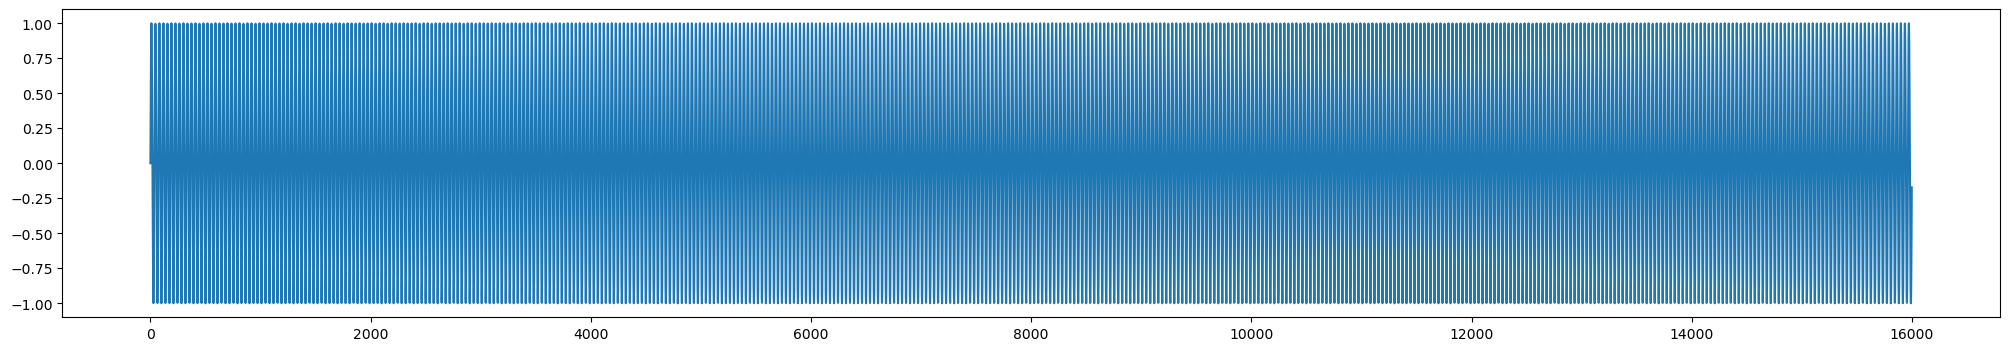

In [3]:
sine_440hz_x, sine_440hz_y = generate_sine_wave(440)

plt.figure(figsize=(25,4))
plt.plot(sine_440hz_x, sine_440hz_y)

ipd.Audio(sine_440hz_y, rate=16_000)

In [4]:
def linear_decay(x, y):
    n_samples = len(x)
    new_y = []
    for i in range(n_samples):
        new_y.append(y[i] * (n_samples - i) / n_samples)
    return x, new_y

In [5]:
def exponential_decay(x, y, rate=1e-2):
    n_samples = len(x)
    new_y = [y[0]]
    for i in range(1, n_samples):
        new_y.append(y[i] * (rate) ** (i / n_samples))
    return x, new_y

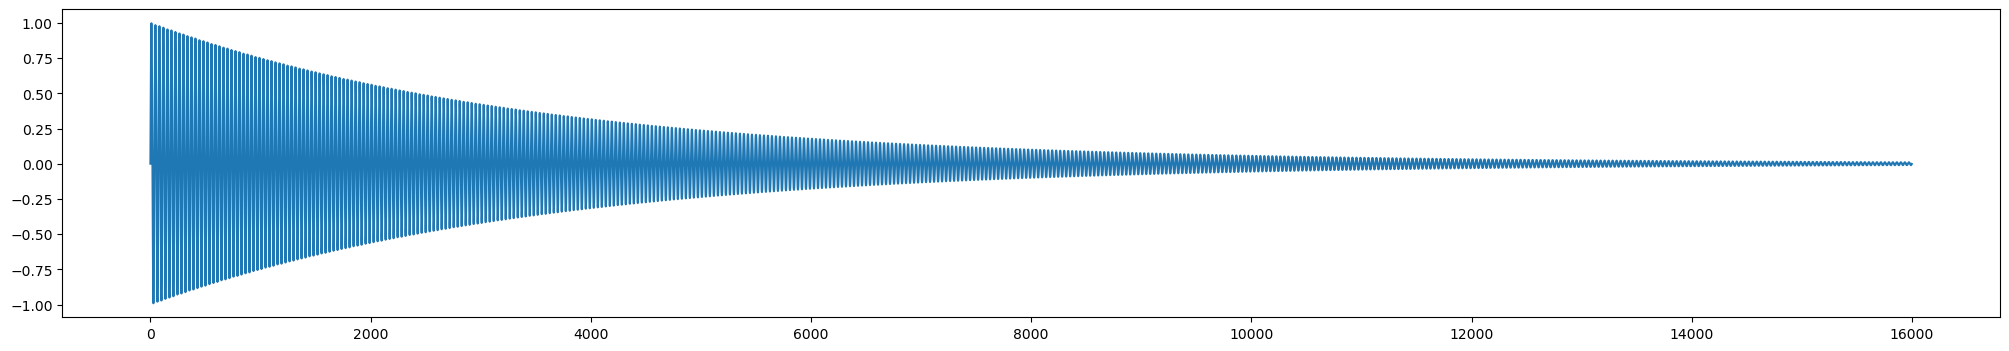

In [6]:
a4_x_decay, a4_y_decay = exponential_decay(sine_440hz_x, sine_440hz_y, rate=1e-2)

plt.figure(figsize=(25,4))
plt.plot(a4_x_decay, a4_y_decay)

ipd.Audio(a4_y_decay, rate=16_000)

In [7]:
def overlay_waves(y1, y2, offset=0, wrap=False):
    composite_y = list(y1)
    n_samples = len(y2)
    for i in range(n_samples):
        if wrap:
            composite_y[i] += y2[(i + offset) % n_samples]
        else:
            if i + offset >= len(y1):
                composite_y.append(y2[i])
            else:
                composite_y[i + offset] += y2[i]

    return composite_y

In [8]:
def apply_filter(sound, filter):
    return sound

In [9]:
def noise_filter(y, noise=0.2):
    noisy_y = y
    n_samples = len(y)
    n_nodes = 10
    noises = []
    for i in range(n_nodes):
        noises.append(np.random.uniform(-1 * noise, noise))
    noise_spline = scipy.interpolate.CubicSpline(np.arange(n_nodes), noises)
    for i in range(n_samples):
        noisy_y[i] -= noisy_y[i] * noise_spline(n_nodes * i / n_samples)
    return noisy_y

In [10]:
def smooth_filter(y, smooth=0):
    smooth_y = y
    return smooth_y

In [11]:
def generate_pitch_with_overtones(n_samples, sampling_rate, amp, freq, n_overtones=10, overtone_noise=0, strengths="harmonic", open=True):
    _, composite_pitch = generate_sine_wave(freq, amp, n_samples, sampling_rate)
    for i in range(2, n_overtones + 1):
        overtone_frequency = freq * i + np.random.normal(0, overtone_noise)
        if strengths == "harmonic":
            overtone_strength = amp / i
        elif strengths == "random":
            overtone_strength = np.random.uniform(0, amp)
        elif strengths == "constant":
            overtone_strength = amp
        else:
            overtone_strength = 0
        _, overtone_y = generate_sine_wave(overtone_frequency, overtone_strength, n_samples, sampling_rate)
        composite_pitch = overlay_waves(composite_pitch, overtone_y, offset=20 * i, wrap=True)
    return np.arange(n_samples), composite_pitch

In [12]:
def soften_attack(y, softness=0.1):
    softened_y = y
    n_samples = len(y)
    for i in range(0, n_samples):
        softened_y[i] *= math.atan(i/(n_samples * softness) / (math.pi/2))
    return softened_y

In [13]:
def soften_release(y, softness=0.1):
    softened_y = y
    n_samples = len(y)
    for i in range(0, n_samples):
        softened_y[n_samples - i - 1] *= math.atan(i/(n_samples * softness) / (math.pi/2))
    return softened_y

In [14]:
def contrast_enhance(y, factor=2):
    enhanced_y = y
    max_amp = max(y)
    n_samples = len(y)
    for i in range(n_samples):
        enhanced_y[i] *= abs(enhanced_y[i]) / max_amp
    return enhanced_y

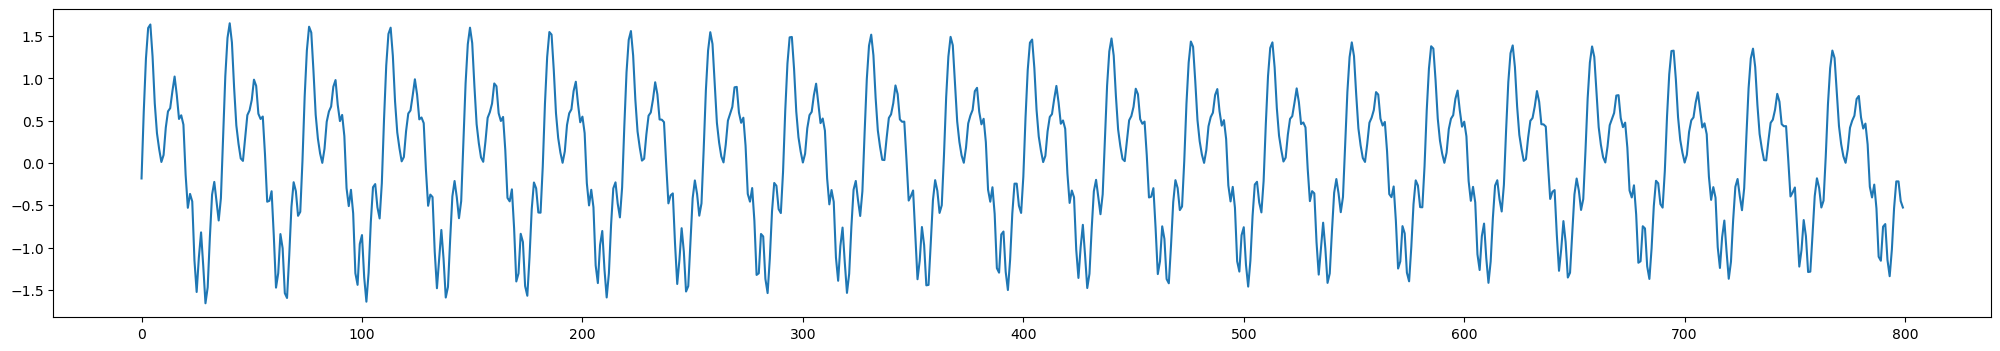

In [15]:
a4_x_overtones, a4_y_overtones = generate_pitch_with_overtones(16000, 16000, 1, 440, 10)
a4_x_overtones, a4_y_overtones = exponential_decay(a4_x_overtones, a4_y_overtones, rate=1e-2)
ipd.Audio(a4_y_overtones, rate=16_000)

# a4_y_overtones = noise_filter(a4_y_overtones, 0.2)

plt.figure(figsize=(25,4))
plt.plot(a4_x_overtones[:800], a4_y_overtones[:800])

ipd.Audio(a4_y_overtones, rate=16_000)

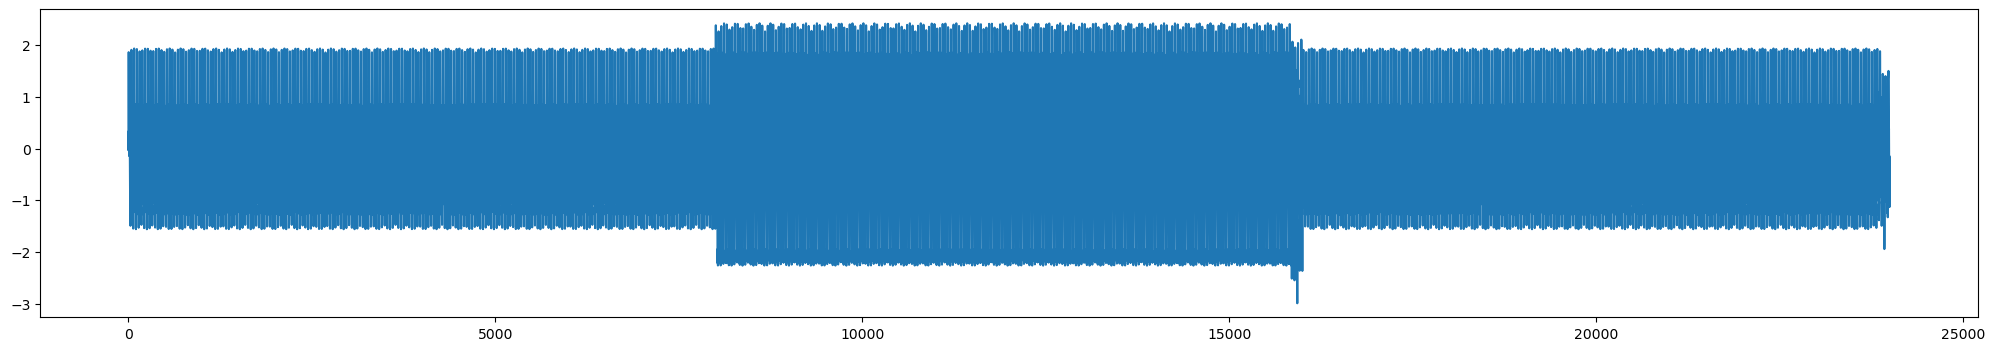

In [16]:
SAMPLING_RATE = 16384
_, a4_1 = generate_pitch_with_overtones(16000, SAMPLING_RATE, 1, 440, 10)
_, a4_2 = generate_pitch_with_overtones(16000, SAMPLING_RATE, 1, 440, 10)
composite_a4 = overlay_waves(a4_1, a4_2, offset=8000, wrap=False)

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(composite_a4)), composite_a4)

ipd.Audio(composite_a4, rate=16_000)

In [17]:
def fast_fourier_transform(y):
    N = len(y)
    
    if N == 1:
        return y
    else:
        Y_even = fast_fourier_transform(y[::2])
        Y_odd = fast_fourier_transform(y[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)
        
        Y = np.concatenate(\
            [Y_even+factor[:int(N/2)]*Y_odd,
             Y_even+factor[int(N/2):]*Y_odd])
        return Y

32104


c:\Users\andre\miniconda3\envs\tf\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


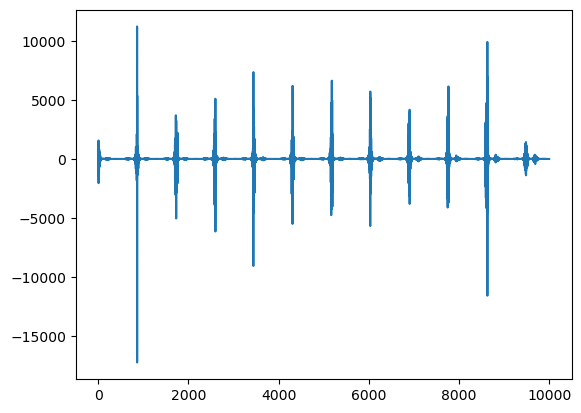

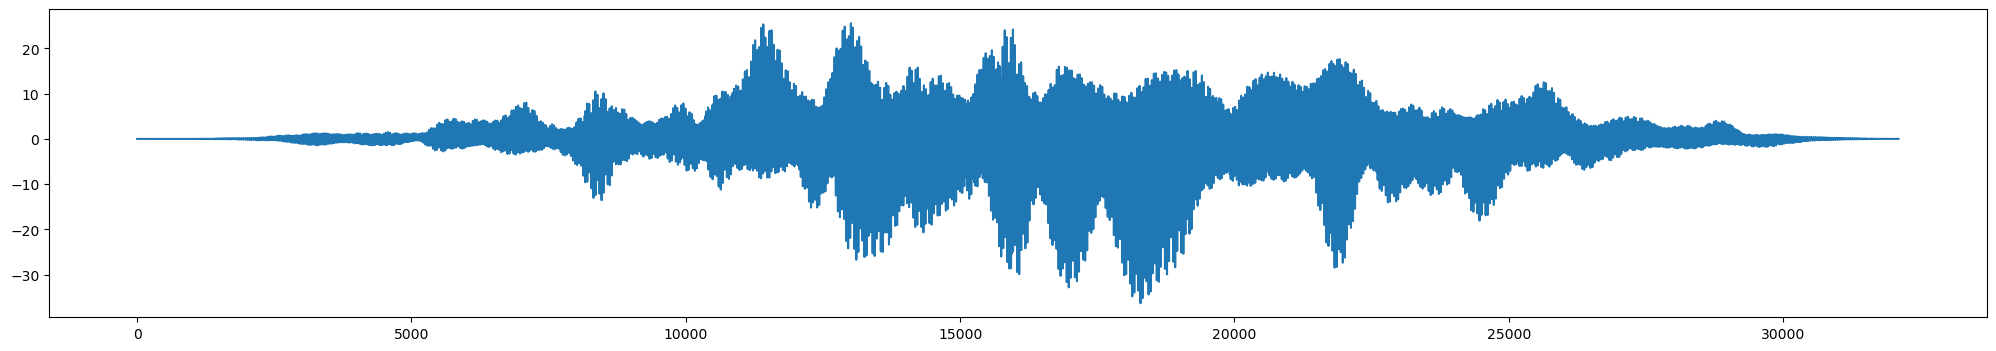

In [18]:
SAMPLING_RATE = 16384
N_SAMPLES = 16384
PITCH_FREQUENCY = 440
strength = []
for i in range(N_SAMPLES):
    strength.append(math.sin((i / N_SAMPLES) * math.pi))
_, composite_a4_y = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, 0, PITCH_FREQUENCY, 10)
pitch_speed = 25
for i in range(1, pitch_speed):
    # pitch_variance = np.random.uniform(-2, 2)
    pitch_variance = np.random.normal(0, 0.2)
    # _, single_a4 = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, strength[i * int(SAMPLING_RATE/pitch_speed)], 440 + pitch_variance, 10)
    _, single_a4 = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, amp=1, freq=440 + pitch_variance, strengths="random", n_overtones=10, overtone_noise=5)
    single_a4 = soften_attack(single_a4, 0.1)
    single_a4 = soften_release(single_a4, 0.1)
    composite_a4_y = overlay_waves(composite_a4_y, single_a4, offset=i * int(SAMPLING_RATE/pitch_speed), wrap=False)

composite_a4_y = contrast_enhance(composite_a4_y)

composite_a4_x = np.arange(len(composite_a4_y))
print(len(composite_a4_x))

fourier_composite = np.fft.fft(composite_a4_y)
plt.plot(np.arange(len(fourier_composite))[:10000], fourier_composite[:10000])

# composite_a4_x, composite_a4_y = exponential_decay(composite_a4_x, composite_a4_y, rate = 1e-1)

plt.figure(figsize=(25,4))
plt.plot(composite_a4_x, composite_a4_y)

ipd.Audio(composite_a4_y, rate=16_000)

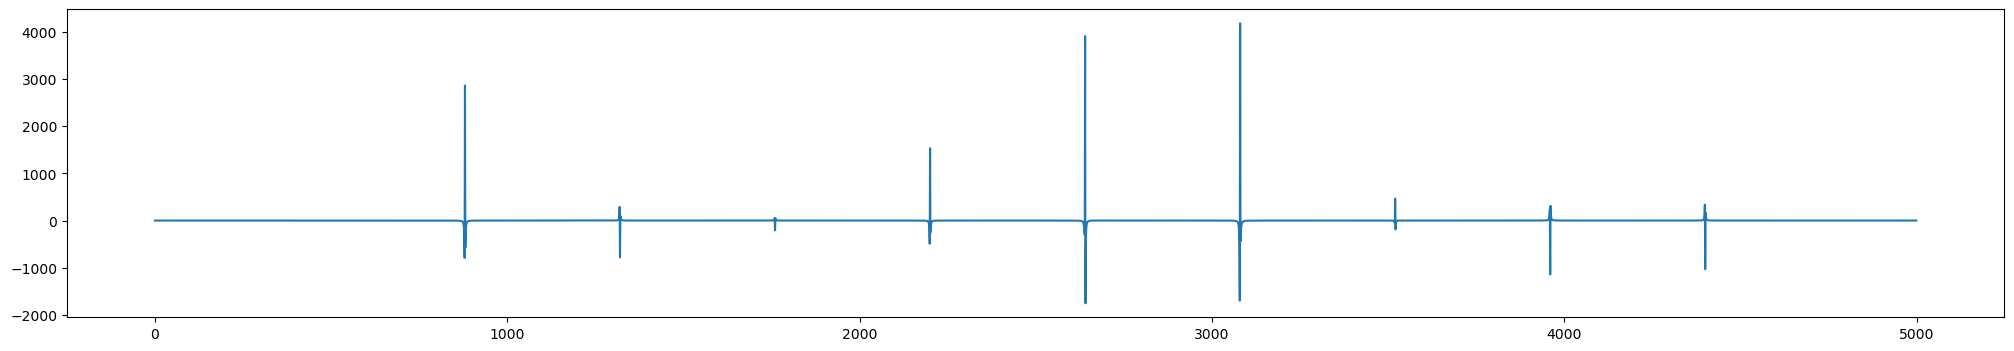

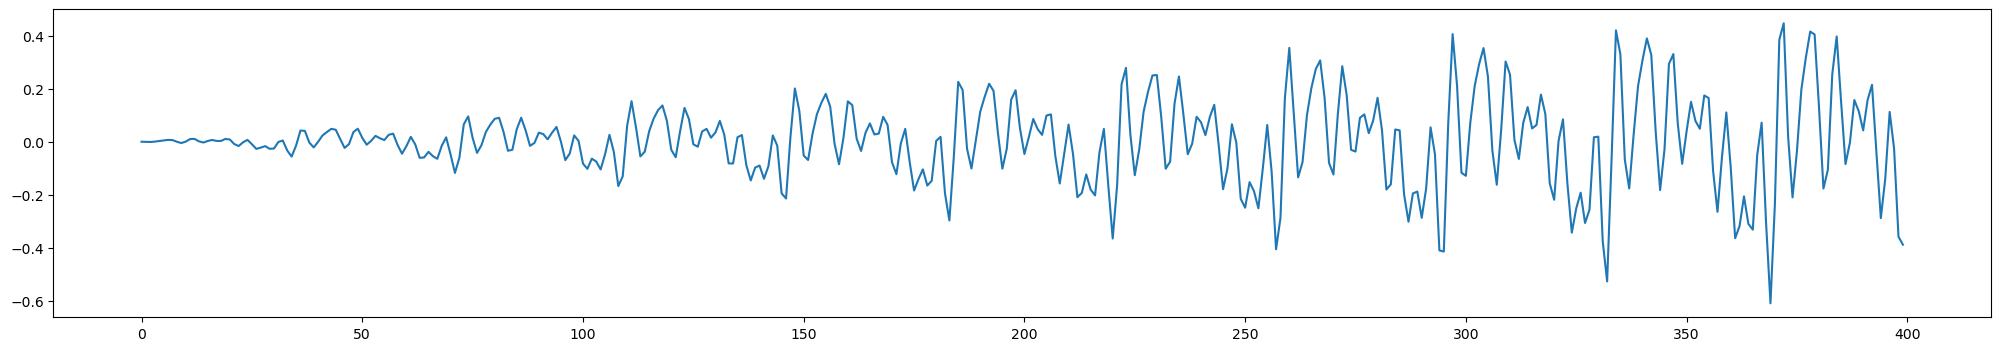

In [21]:
SAMPLING_RATE = 16384
N_SAMPLES = 16384
PITCH_FREQUENCY = 440

_, single_a4 = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, amp=1, freq=440, n_overtones=10, strengths="random", overtone_noise=0.1)
single_a4 = soften_attack(single_a4, 0.1)
single_a4 = soften_release(single_a4, 0.1)

fourier_a4 = np.fft.fft(single_a4)

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(fourier_a4) // 2)[:5000], fourier_a4[:5000])

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(single_a4))[:400], single_a4[:400])

ipd.Audio(single_a4, rate=16_000)